### This notebook is used to analyze the tracking results generated by the QuPath CEDAR extension.

**Note:** It would be nicer to have another project to have this notebook and other related files. For the time being, this is the best place since it can be grouped together with other Python code.

**Note**: The env used for this notebook is monai at MacBook Pro (2023)

### Load the necessary packages

In [1]:
import pandas as pd

### Set up some parameters

In [2]:
working_dir = '/Users/wug/Documents/wgm/work/cedar_nvidia/tracking_analysis'
src_file = '{}/manual_action_tracking.tsv'.format(working_dir)
print('src_file: {}'.format(src_file))

ftu_action_time_file = '{}/ftu_manual_action_time.csv'.format(working_dir)

src_file: /Users/wug/Documents/wgm/work/cedar_nvidia/tracking_analysis/manual_action_tracking.tsv


### Load the tracking results into a DataFrame

In [3]:
tracking_df = pd.read_csv(src_file, sep='\t')
tracking_df.head()

,id,Action,Start Time (ms),End Time (ms),Duration (ms),Property Name,New Property Value,Old Property Value,Time Stamp
0,2,Image Loading,1733867704470,1733867708570,4100,Image File,C:\Users\sevim\Documents\ACED\Batch2\images\00...,NaN,2024-12-10 13:55:04
1,3,Annotation Loading,1733867708570,1733867709856,1286,Annotation File,C:\Users\sevim\Documents\ACED\Batch2\annotatio...,NaN,2024-12-10 13:55:08
2,5,Image Loading,1733867714225,1733867717611,3386,Image File,C:\Users\sevim\Documents\ACED\Batch2\images\02...,NaN,2024-12-10 13:55:14
3,6,Annotation Loading,1733867717612,1733867717709,97,Annotation File,C:\Users\sevim\Documents\ACED\Batch2\annotatio...,NaN,2024-12-10 13:55:17
4,8,Image Loading,1733867739365,1733867742670,3305,Image File,C:\Users\sevim\Documents\ACED\Batch2\images\02...,NaN,2024-12-10 13:55:39


In [4]:
analyzed_actions = tracking_df['Action'].unique()
print('All actions ({}): {}'.format(len(analyzed_actions), analyzed_actions))

# The following actions will not be analyzed since no FTU associated with them
excluded_actions = [
    'Image Loading',
    'Annotation Loading',
    'Saving an Annotation', # Need to change it to "Saving Annotation"
    'Annotation Inference',
    'Annotation Structure Editing' # Large change: cannot track it
]
analyzed_actions = [action for action in analyzed_actions if not action in excluded_actions]
print('To be tracked ({}): {}'.format(len(analyzed_actions), analyzed_actions))

All actions (12): ['Image Loading' 'Annotation Loading' 'Annotation Selection in Image'
 'Annotation Deletion' 'Annotation Creation' 'Saving an Annotation'
 'Annotation Structure Editing' 'Annotation Table Selection'
 'Annotation Inference' 'Annotation Moving' 'Annotation Editing'
 'Classification Change in Image']
To be tracked (7): ['Annotation Selection in Image', 'Annotation Deletion', 'Annotation Creation', 'Annotation Table Selection', 'Annotation Moving', 'Annotation Editing', 'Classification Change in Image']


### Convert the results for each FTU

In [5]:
class FTU_Annotaton_Action:
    def __init__(self, id, action, start_time, end_time, action_id):
        self.id = id
        self.action = action
        self.start_time = start_time
        self.end_time = end_time
        self.action_id = action_id
        self.pre_action_end_time = None
        self.image = None
        self.new_class_value = None
        self.old_class_value = None

In [6]:
# Iterate each row of tracking_df
from collections import defaultdict

action_2_example = {}
for index, row in tracking_df.iterrows():
    action = row['Action']
    if not action in analyzed_actions:
        continue
    action_2_example[action] = row

for action, example in action_2_example.items():
    print('{}\n{}'.format(action, example))
    print()

Annotation Selection in Image
id                                                                 7719
Action                                    Annotation Selection in Image
Start Time (ms)                                           1734653401809
End Time (ms)                                             1734653401810
Duration (ms)                                                         1
Property Name                                             Selected Item
New Property Value    d33aa42e-4a3e-43e1-b936-7b77383639d0: -1,-1,ma...
Old Property Value                                                  NaN
Time Stamp                                          2024-12-19 16:10:01
Name: 7524, dtype: object

Annotation Deletion
id                                                                 7717
Action                                              Annotation Deletion
Start Time (ms)                                           1734653397983
End Time (ms)                                             1

In [7]:
id_2_annotation_actions = defaultdict(list)
id_2_image = {}
pre_end_time = None
image = None
for index, row in tracking_df.iterrows():
    action = row['Action']
    if action == 'Image Loading':
        image = row['New Property Value']
    if not action in analyzed_actions:
        # Regardless if we need this action, we need its pre_end_time
        pre_end_time = row['End Time (ms)']
        continue
    ftuIf = None
    if action == 'Annotation Editing':
        ftuId = row['Property Name'].split(':')[1].strip()
    elif action == 'Classification Change in Image':
        ftuId = row['Property Name'].split(':')[0].strip()
    else:
        ftuId = row['New Property Value'].split(':')[0].strip()
    actionAnnotation = FTU_Annotaton_Action(ftuId, 
                                            action, 
                                            row['Start Time (ms)'], 
                                            row['End Time (ms)'],
                                            row['id'])
    actionAnnotation.image = image
    if action in ['Annotation Editing', 'Classification Change in Image']:
        actionAnnotation.old_class_value = row['Old Property Value']
        actionAnnotation.new_class_value = row['New Property Value']
    id_2_image[ftuId] = image
    id_2_annotation_actions[ftuId].append(actionAnnotation)
    actionAnnotation.pre_action_end_time = pre_end_time
    pre_end_time = actionAnnotation.end_time

# Perform a filtered
manual_ftu_annotation_actions = {id: action_actions for id, action_actions 
                                in id_2_annotation_actions.items() 
                                if 'manuel' in id_2_image[id]}

print('Total FTUs by manual editing: {}\n'.format(len(manual_ftu_annotation_actions)))

count = 0
for id, action_annotations in manual_ftu_annotation_actions.items():
    print(id)
    for action_annotation in action_annotations:
        print('{},{},{},{},{},{},{},{}'.format(action_annotation.action_id,
                                   action_annotation.action,
                                   action_annotation.start_time,
                                   action_annotation.end_time,
                                   action_annotation.pre_action_end_time,
                                   action_annotation.old_class_value if action_annotation.old_class_value else '',
                                   action_annotation.new_class_value if action_annotation.new_class_value else '',
                                   action_annotation.image))
    print()
    if count == 2:
        break
    count += 1

Total FTUs by manual editing: 384

eadd4a29-4fb5-43b5-a7f0-9ed03aaea355
6093,Annotation Creation,1734644183640,1734644183641,1734644132673,,,C:\Users\sevim\Documents\ACED\Manuel evaluation\images\manuel-005_1_A_(4)_5.ome.tif
6094,Annotation Selection in Image,1734644183641,1734644183649,1734644183641,,,C:\Users\sevim\Documents\ACED\Manuel evaluation\images\manuel-005_1_A_(4)_5.ome.tif
6212,Annotation Selection in Image,1734644614360,1734644614361,1734644610993,,,C:\Users\sevim\Documents\ACED\Manuel evaluation\images\manuel-005_1_A_(4)_5.ome.tif
6213,Annotation Editing,1734644616370,1734644616370,1734644614361,-1,12,C:\Users\sevim\Documents\ACED\Manuel evaluation\images\manuel-005_1_A_(4)_5.ome.tif

b9aafb5a-74a7-43ae-a0b5-7c61faae3733
6095,Annotation Creation,1734644203532,1734644203532,1734644183649,,,C:\Users\sevim\Documents\ACED\Manuel evaluation\images\manuel-005_1_A_(4)_5.ome.tif
6096,Annotation Selection in Image,1734644203533,1734644203534,1734644203532,,,C:\Users\sevim\Document

### Plot histogram for the time spent for each FTU in manual editing

In [8]:
# Load the class id to class name map so that we can analyze based either class id or class name. Right now they are mixed.
import pandas as pd

class_id_name_file = 'lib/configs/prostate_cancer_path_classes.txt'
# Make sure to use string for the mapping
class_id_name_df = pd.read_csv(class_id_name_file, sep='\t', dtype=str)
# class_id_name_df

# Create mappings
class_id_to_name = dict(zip(class_id_name_df['class_id'], class_id_name_df['class_name']))
class_name_to_id = dict(zip(class_id_name_df['class_name'], class_id_name_df['class_id']))

# Example usage
print(class_id_to_name)
print(class_name_to_id)

{'0': 'unlabeled', '1': 'gleason 3', '2': 'gleason 4 cribriform glands', '3': 'gleason 4 poorly formed glands', '4': 'gleason 4 fused glands', '5': 'gleason 4 glomeruloid glands', '6': 'gleason 5 single cells', '7': 'gleason 5 sheets', '8': 'gleason 5 cords', '9': 'gleason 5 solid nests', '10': 'gleason 5 necrosis', '11': 'prostatic intraepithelial neoplasia', '12': 'benign gland', '13': 'glandular atrophy', '14': 'nerve', '15': 'vein/artery', '16': 'chronic inflammation', '17': 'background stroma', '18': 'not segmented correctly', '19': 'tissue processing artifact'}
{'unlabeled': '0', 'gleason 3': '1', 'gleason 4 cribriform glands': '2', 'gleason 4 poorly formed glands': '3', 'gleason 4 fused glands': '4', 'gleason 4 glomeruloid glands': '5', 'gleason 5 single cells': '6', 'gleason 5 sheets': '7', 'gleason 5 cords': '8', 'gleason 5 solid nests': '9', 'gleason 5 necrosis': '10', 'prostatic intraepithelial neoplasia': '11', 'benign gland': '12', 'glandular atrophy': '13', 'nerve': '14',

In [9]:
# Create a dataframe for each FTU
ftu_time_df = pd.DataFrame(columns=['FTU_id', 'duration_with_start_time', 'duration_with_pre_end_time', 'FTU_class_id', 'FTU_class_name'])
row = 0
for id, action_annotations in manual_ftu_annotation_actions.items():
    time_1 = 0
    time_2 = 0
    class_id = None
    class_name = None
    for annotation_action in action_annotations:
        # Use the end time
        time_1 += (annotation_action.end_time - annotation_action.start_time)
        time_2 += (annotation_action.end_time - annotation_action.pre_action_end_time 
                   if annotation_action.pre_action_end_time 
                   else annotation_action.start_time)
        class_value = annotation_action.new_class_value
        # Figure out id and name
        if class_value in class_id_to_name.keys():
            class_id = class_value
            class_name = class_id_to_name[class_id]
        elif class_value in class_name_to_id.keys():
            class_name = class_value
            class_id = class_name_to_id[class_name]
    ftu_time_df.loc[row] = [id, time_1, time_2, class_id, class_name]
    row += 1

ftu_time_df.sort_values(by='duration_with_pre_end_time', inplace=True, ascending=False)
# ftu_time_df.to_csv(ftu_action_time_file)
# print('Write to {}'.format(ftu_action_time_file))
print(ftu_time_df.head(5))

                                   FTU_id  duration_with_start_time  \
243  f621c549-436b-4d55-bf79-63f3412a2007                         4   
40   b1337d95-0949-4ad9-841d-b3c1df19e6fc                         4   
262  779af42f-b801-4046-83f5-1c86dea20b72                         2   
0    eadd4a29-4fb5-43b5-a7f0-9ed03aaea355                        10   
244  d4a041a5-c5aa-4ec5-ae6e-35492d9511ac                         1   

     duration_with_pre_end_time FTU_class_id                  FTU_class_name  
243                       85427            4          gleason 4 fused glands  
40                        83211           12                    benign gland  
262                       67497            3  gleason 4 poorly formed glands  
0                         56353           12                    benign gland  
244                       50799            3  gleason 4 poorly formed glands  


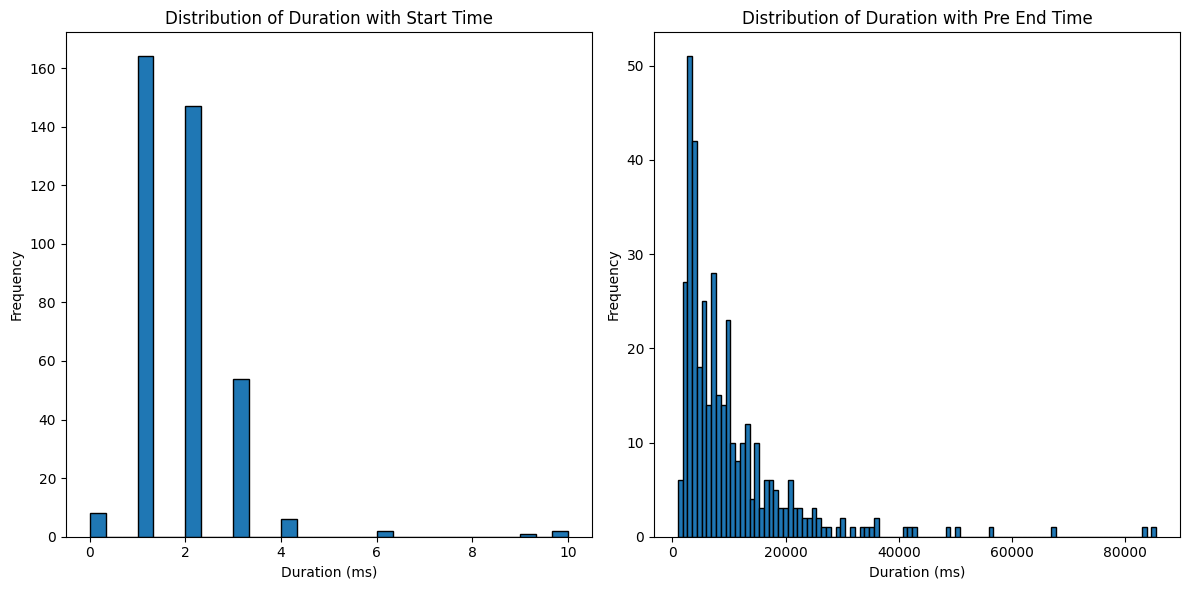

In [10]:
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

# Plotting the distributions
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(ftu_time_df['duration_with_start_time'], bins=30, edgecolor='black')
plt.title('Distribution of Duration with Start Time')
plt.xlabel('Duration (ms)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(ftu_time_df['duration_with_pre_end_time'], bins=100, edgecolor='black')
plt.title('Distribution of Duration with Pre End Time')
plt.xlabel('Duration (ms)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


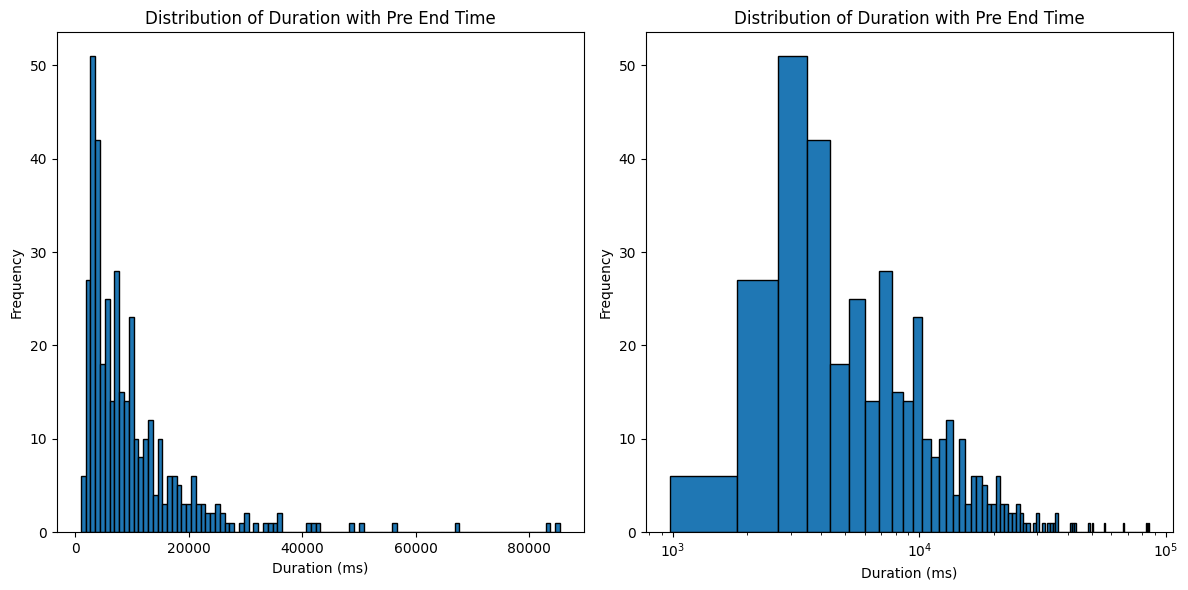

In [11]:
# Plotting the distributions
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(ftu_time_df['duration_with_pre_end_time'], bins=100, edgecolor='black')
plt.title('Distribution of Duration with Pre End Time')
plt.xlabel('Duration (ms)')
plt.ylabel('Frequency')
# plt.xscale('log')

plt.subplot(1, 2, 2)
plt.hist(ftu_time_df['duration_with_pre_end_time'], bins=100, edgecolor='black')
plt.title('Distribution of Duration with Pre End Time')
plt.xlabel('Duration (ms)')
plt.ylabel('Frequency')
plt.xscale('log')

plt.tight_layout()
plt.show()

#### Analyze for individual classes

In [14]:
ftu_id_name_df = ftu_time_df[['FTU_class_id', 'FTU_class_name']].drop_duplicates()
print(ftu_id_name_df)
# print(ftu_time_df['FTU_class_id'].unique())
# print(ftu_time_df['FTU_class_name'].unique())

value_counts = ftu_time_df.value_counts(['FTU_class_id', 'FTU_class_name'])
print()
print(value_counts)

ftu_time_df['gleason_grade'] = ftu_time_df['FTU_class_name'].map(
    lambda name: f"gleason {name.split(' ')[1]}" if name and 'gleason' in name else name
)
ftu_time_df['gleason_grade'] = ftu_time_df['gleason_grade'].map(
    lambda name: 'Non-tumoral' if name == 'benign gland' or name == 'glandular atrophy' else name
)
print()
value_counts = ftu_time_df.value_counts(['gleason_grade'])
print(value_counts)

    FTU_class_id                  FTU_class_name
243            4          gleason 4 fused glands
40            12                    benign gland
262            3  gleason 4 poorly formed glands
310         None                            None
86            13               glandular atrophy
205            1                       gleason 3
381            5    gleason 4 glomeruloid glands
349            2     gleason 4 cribriform glands

FTU_class_id  FTU_class_name                
3             gleason 4 poorly formed glands    108
1             gleason 3                         104
13            glandular atrophy                  64
12            benign gland                       45
2             gleason 4 cribriform glands         6
4             gleason 4 fused glands              3
5             gleason 4 glomeruloid glands        3
Name: count, dtype: int64

gleason_grade
gleason 4        120
Non-tumoral      109
gleason 3        104
Name: count, dtype: int64


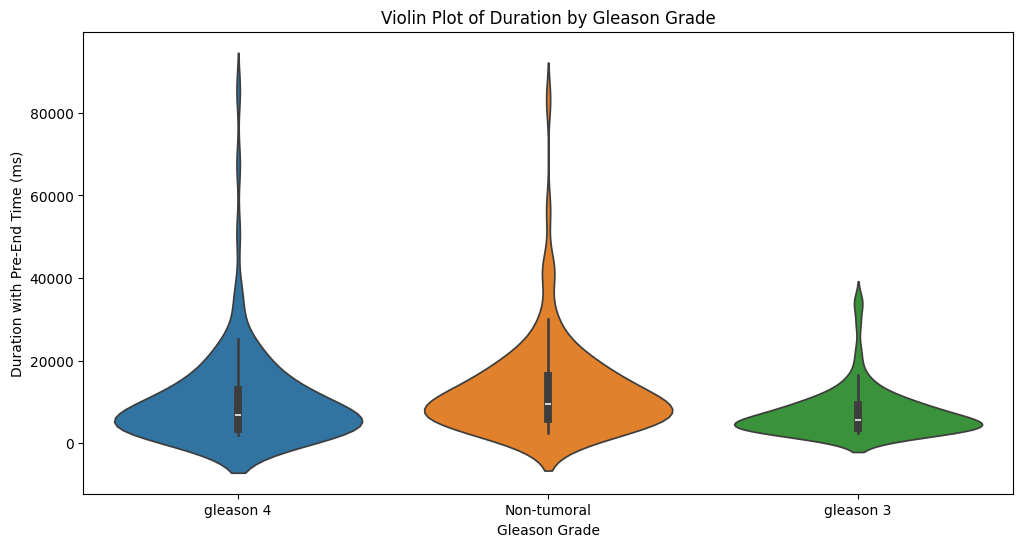

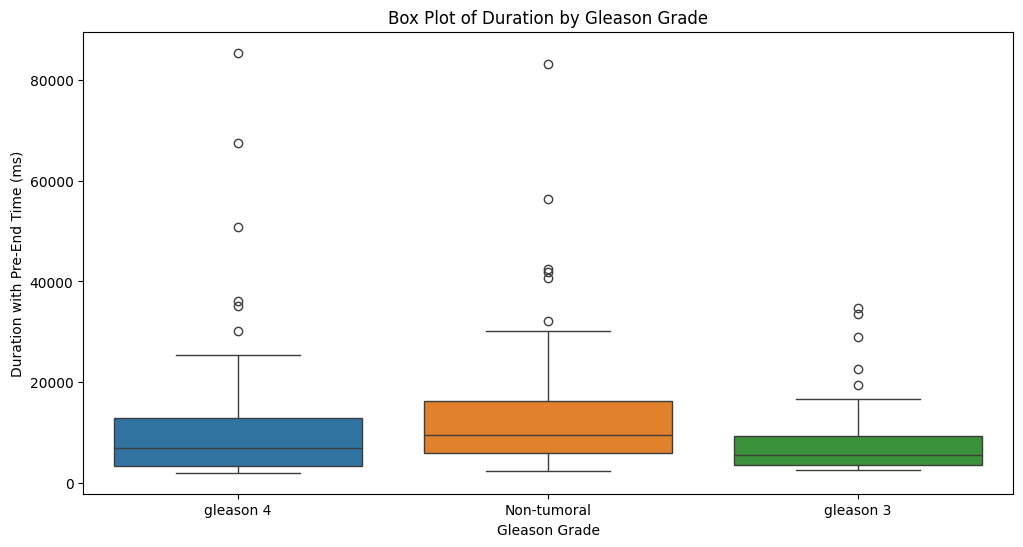

In [15]:
#!pip install seaborn
import seaborn as sns

# Set the figure size
plt.figure(figsize=(12, 6))
sns.violinplot(x='gleason_grade', y='duration_with_pre_end_time', data=ftu_time_df, hue='gleason_grade', legend=False)
plt.xlabel('Gleason Grade')
plt.ylabel('Duration with Pre-End Time (ms)')
plt.title('Violin Plot of Duration by Gleason Grade')
plt.show()
# Set the figure size
plt.figure(figsize=(12, 6))
sns.boxplot(x='gleason_grade', y='duration_with_pre_end_time', data=ftu_time_df, hue='gleason_grade', legend=False)
plt.xlabel('Gleason Grade')
plt.ylabel('Duration with Pre-End Time (ms)')
plt.title('Box Plot of Duration by Gleason Grade')
plt.show()

In [16]:
# Output mean and sd
# Group by `gleason_grade` and calculate mean and standard deviation
stats = ftu_time_df.groupby('gleason_grade')['duration_with_pre_end_time'].agg(['mean', 'std'])

# Reset the index for easier display
stats.reset_index(inplace=True)

# Print the results
print(stats)

  gleason_grade          mean           std
0   Non-tumoral  12915.770642  11495.892893
1     gleason 3   7358.144231   5826.237967
2     gleason 4  10577.233333  11936.027517


#### Perform pair-wise test

In [17]:
#!pip install scikit-posthocs
import scikit_posthocs as sp

# Perform pairwise Dunn's test
ftu_time_df_no_na = ftu_time_df.dropna(inplace=False)
ftu_time_df_no_na.head()
dunn_results = sp.posthoc_dunn(ftu_time_df_no_na, val_col='duration_with_pre_end_time', group_col='gleason_grade', p_adjust='bonferroni')

print("Pairwise Dunn's Test Results:")
print(dunn_results)

Pairwise Dunn's Test Results:
             Non-tumoral  gleason 3  gleason 4
Non-tumoral     1.000000   0.000002   0.001446
gleason 3       0.000002   1.000000   0.331395
gleason 4       0.001446   0.331395   1.000000


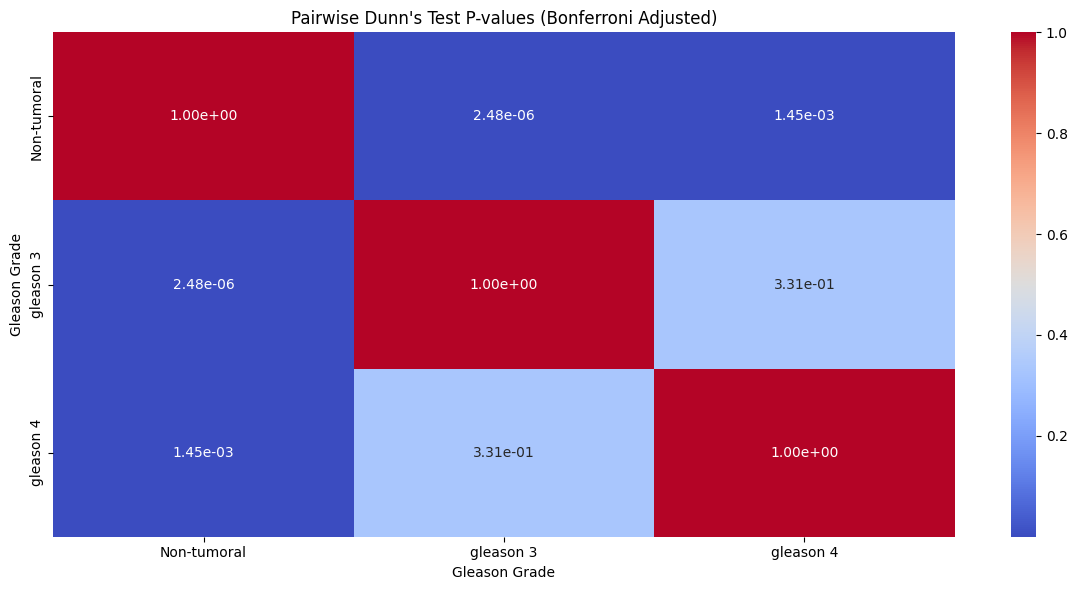

In [18]:
# Plot the heatmap of pairwise p-values
plt.figure(figsize=(12, 6))
sns.heatmap(dunn_results, annot=True, cmap='coolwarm', cbar=True, fmt=".2e")

# Add labels and title
plt.title("Pairwise Dunn's Test P-values (Bonferroni Adjusted)")
plt.xlabel("Gleason Grade")
plt.ylabel("Gleason Grade")
plt.tight_layout()
plt.show()